#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_mag_gsc_eval3', 'improved_mag_gsc_eval4']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc
0,"0_model=DSNNWeightedMag,on_perc=0.0",0.092960,19,0.087052,47,0.089689,0.089542,0.103448,22,0.000000,...,DSNNWeightedMag,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
1,"1_model=DSNNMixedHeb,on_perc=0.0",0.091934,24,0.085880,33,0.089591,0.089542,0.103448,10,0.000000,...,DSNNMixedHeb,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
2,"2_model=SparseModel,on_perc=0.0",0.092325,38,0.085587,99,0.089322,0.085587,0.103448,5,0.000000,...,SparseModel,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
3,"3_model=DSNNWeightedMag,on_perc=0.005",0.399522,7,0.156821,0,0.199736,0.196026,0.394592,8,0.145376,...,DSNNWeightedMag,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3
4,"4_model=DSNNMixedHeb,on_perc=0.005",0.365931,11,0.181330,0,0.296016,0.296065,0.362461,11,0.087382,...,DSNNMixedHeb,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc'],
      dtype='object')

In [7]:
df.shape

(269, 41)

In [8]:
df.iloc[1]

Experiment Name                          1_model=DSNNMixedHeb,on_perc=0.0
train_acc_max                                                   0.0919344
train_acc_max_epoch                                                    24
train_acc_min                                                   0.0858803
train_acc_min_epoch                                                    33
train_acc_median                                                0.0895909
train_acc_last                                                   0.089542
val_acc_max                                                      0.103448
val_acc_max_epoch                                                      10
val_acc_min                                                             0
val_acc_min_epoch                                                       0
val_acc_median                                                  0.0971787
val_acc_last                                                    0.0971787
val_acc_all             0     0.000000

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       90
DSNNWeightedMag    90
SparseModel        89
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

5

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(264, 41)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

264    26
265    23
266    26
267    11
268     1
Name: epochs, dtype: int64

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   54       0.103  0.954  0.823  0.228    88
DSNNWeightedMag                63       0.103  0.952  0.834  0.223    88
SparseModel                    74       0.103  0.949  0.808  0.238    88

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                  10       0.103  0.106  0.104  0.001    15
0.005                  25       0.218  0.425  0.352  0.059    15
0.010                  35       0.609  0.732  0.666  0.044    15
0.015                  40       0.735  0.822  0.779  0.028    15
0.020                  50       0.807  0.880  0.836  0.025    12
0.025                  56       0.841  0.905  0.875  0.021    12
0.030                  73       0.865  0.915  0.891  0.016    12
0.035                  69       0.878  0.922  0.900  0.015    12
0.040                  70       0.895  0.927  0.914  0.010    12
0.045                  77       0.910  0.942  0.926  0.009    12
0.050                  78       0.915  0.938  0.927  0.006    12
0.055                  73       0.928  0.942  0.933  0.004    12
0.060                  73       0.931  0.947  0.936  0.005    12
0.065                  82       0.929  0.947  0.940  0.006    12
0.070                  74       0.924  0.947  0.938  0.006    12
0.075                  84       0.939  0.949  0.944  0.003    12
0.080                  80       0.938  0.952  0.944  0.004    12
0.085                  82       0.938  0.951  0.945  0.004    12
0.090                  83       0.943  0.951  0.948  0.002    12
0.095                  74       0.942  0.954  0.947  0.003    12
0.100                  83       0.946  0.954  0.949  0.002    12

In [29]:
agg(['on_perc', 'model'], df['on_perc'] == 0.04)

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.04    DSNNMixedHeb                   46       0.911  0.916  0.914  0.002   
        DSNNWeightedMag                84       0.922  0.927  0.924  0.002   
        SparseModel                    81       0.895  0.909  0.902  0.006   

                        model  
                        count  
on_perc model                  
0.04    DSNNMixedHeb        4  
        DSNNWeightedMag     4  
        SparseModel         4

In [30]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'Dynamic Sparse Neural Network (DSNN)',
    'DSNNMixedHeb': 'Sparse Evolutionary Training (SET)',
    'SparseModel': 'Static Sparse',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

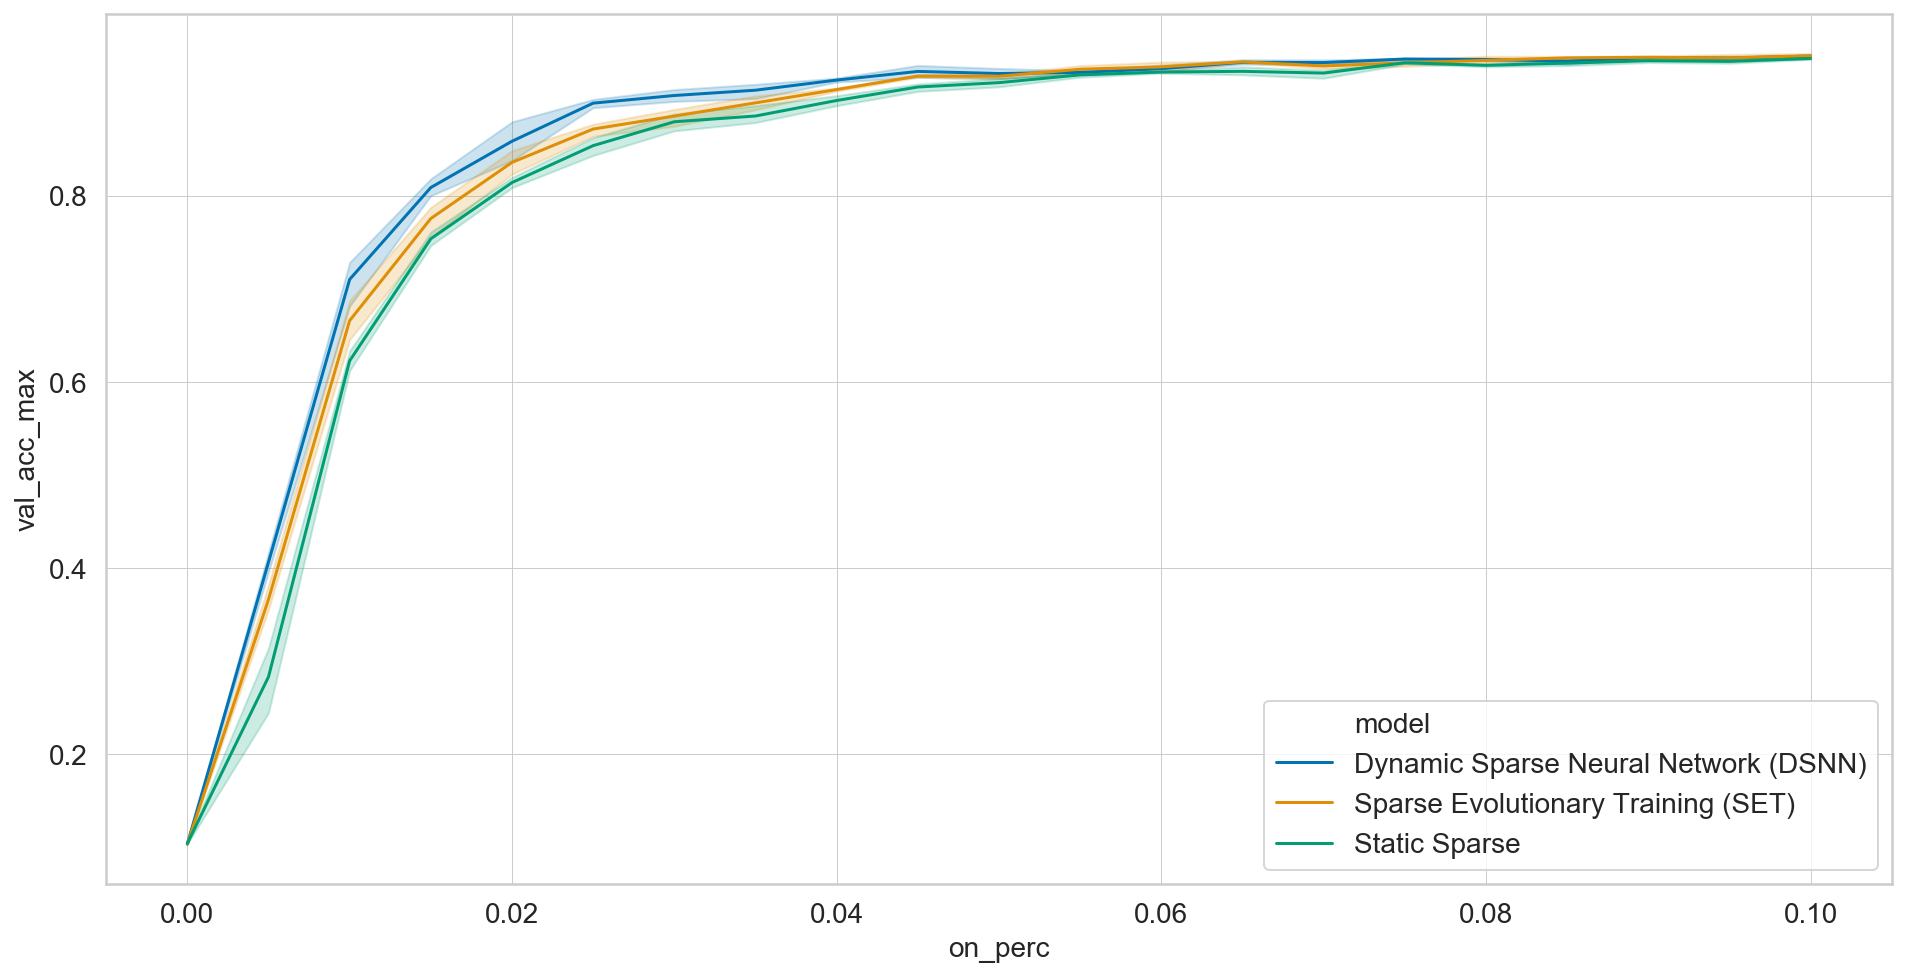

In [31]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

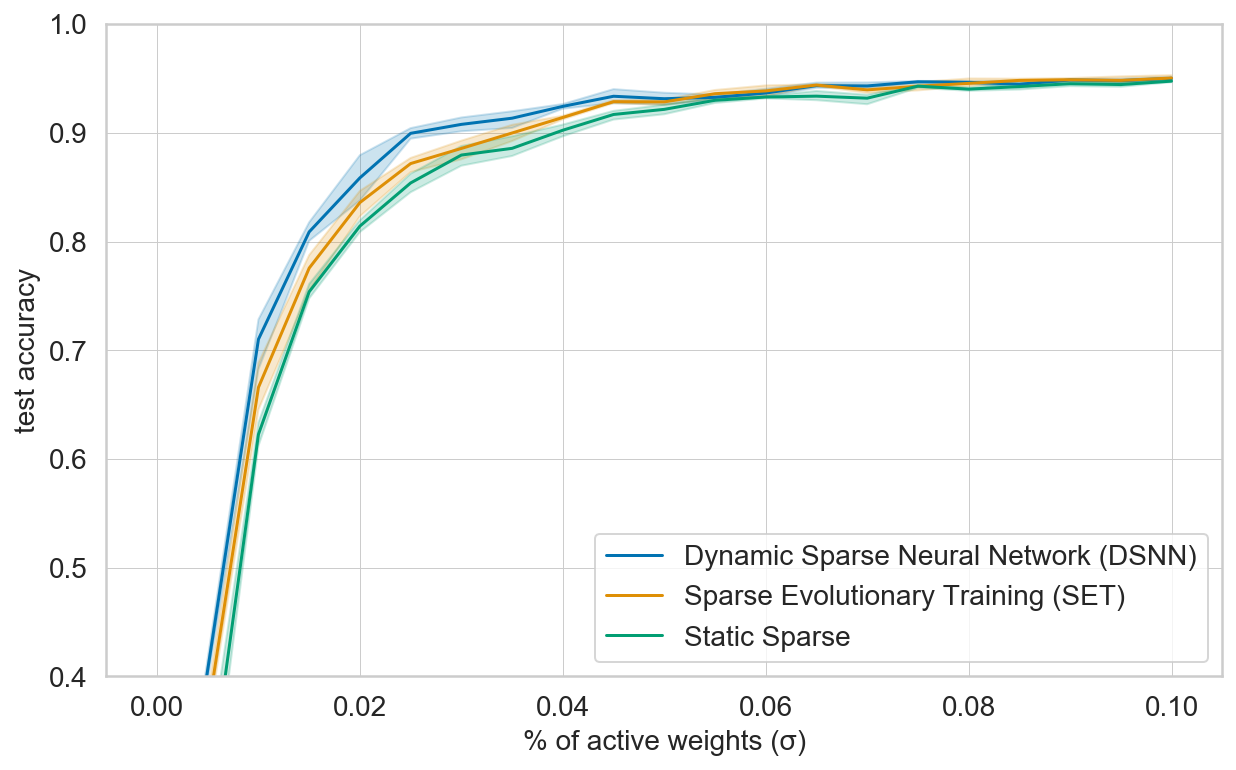

In [34]:
def plot_for_paper():
    rcParams['figure.figsize'] = 10,6
    matplotlib.rc('xtick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('ytick', labelsize=14)
    plt.rcParams.update({'axes.labelsize': 14})
    plt.rcParams.update({'legend.fontsize': 14, 'legend.loc': 'lower right'})
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({"axes.grid": True, "grid.linewidth": 0.5})
    

plot_for_paper()

fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.xlabel("% of active weights (σ)")
plt.ylabel("test accuracy")
plt.ylim((0.4, 1.0))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig('active_weights.png', dpi=300, bbox_inches='tight')

In [20]:
    # plt.rcParams['figure.figsize'] = (8, 3)
    font_size=12
#     plt.rcParams.update({'font.size': font_size})
#     plt.rcParams.update({'font.family': 'Times New Roman'})
#     plt.rcParams.update({'axes.labelsize': font_size})
#     plt.rcParams.update({'axes.titlesize': 1.5*font_size})
#     plt.rcParams.update({'legend.fontsize': font_size})
#     plt.rcParams.update({'xtick.labelsize': font_size})
#     plt.rcParams.update({'ytick.labelsize': font_size})
#     plt.rcParams.update({'savefig.dpi': 2*plt.rcParams['savefig.dpi']})
#     plt.rcParams.update({'xtick.major.size': 3})
#     plt.rcParams.update({'xtick.minor.size': 3})
#     plt.rcParams.update({'xtick.major.width': 1})
#     plt.rcParams.update({'xtick.minor.width': 1})
#     plt.rcParams.update({'ytick.major.size': 3})
#     plt.rcParams.update({'ytick.minor.size': 3})
#     plt.rcParams.update({'ytick.major.width': 1})
#     plt.rcParams.update({'ytick.minor.width': 1 })
    # plt.rcParams.update({})

(0.8, 0.98)

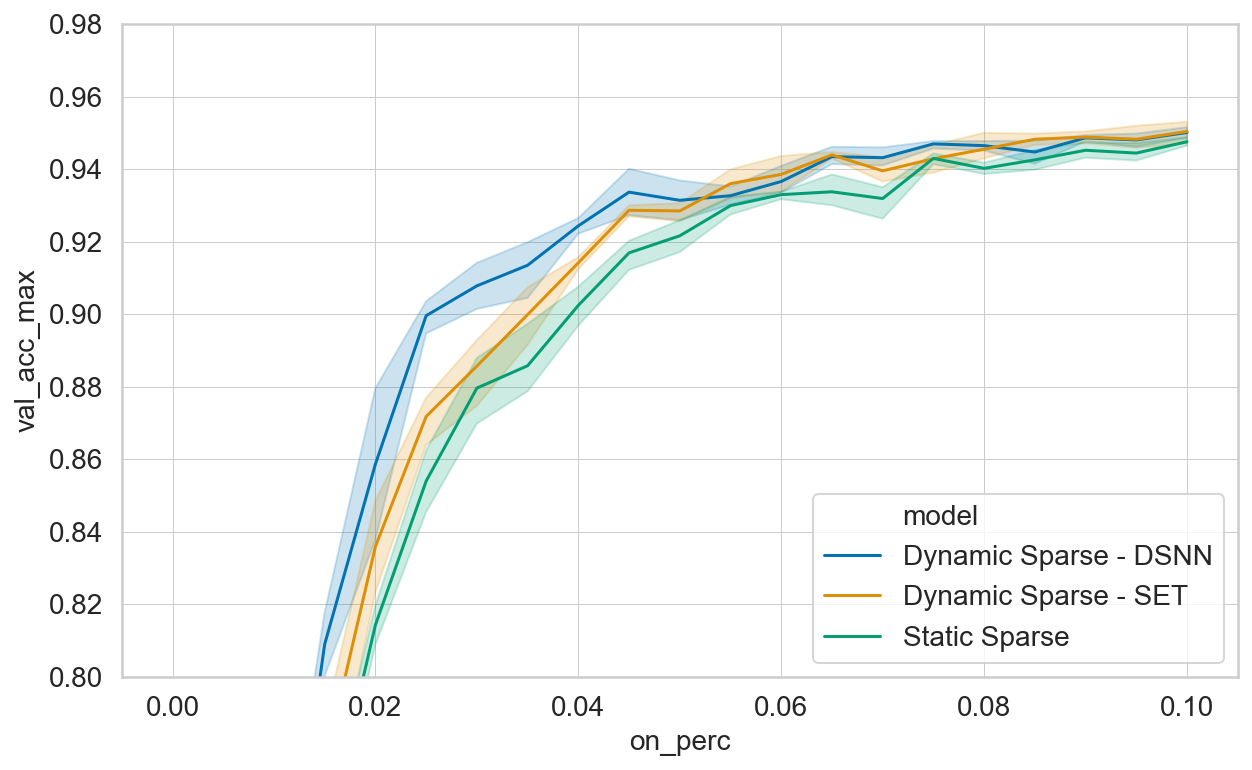

In [21]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.ylim(0.8,0.98)

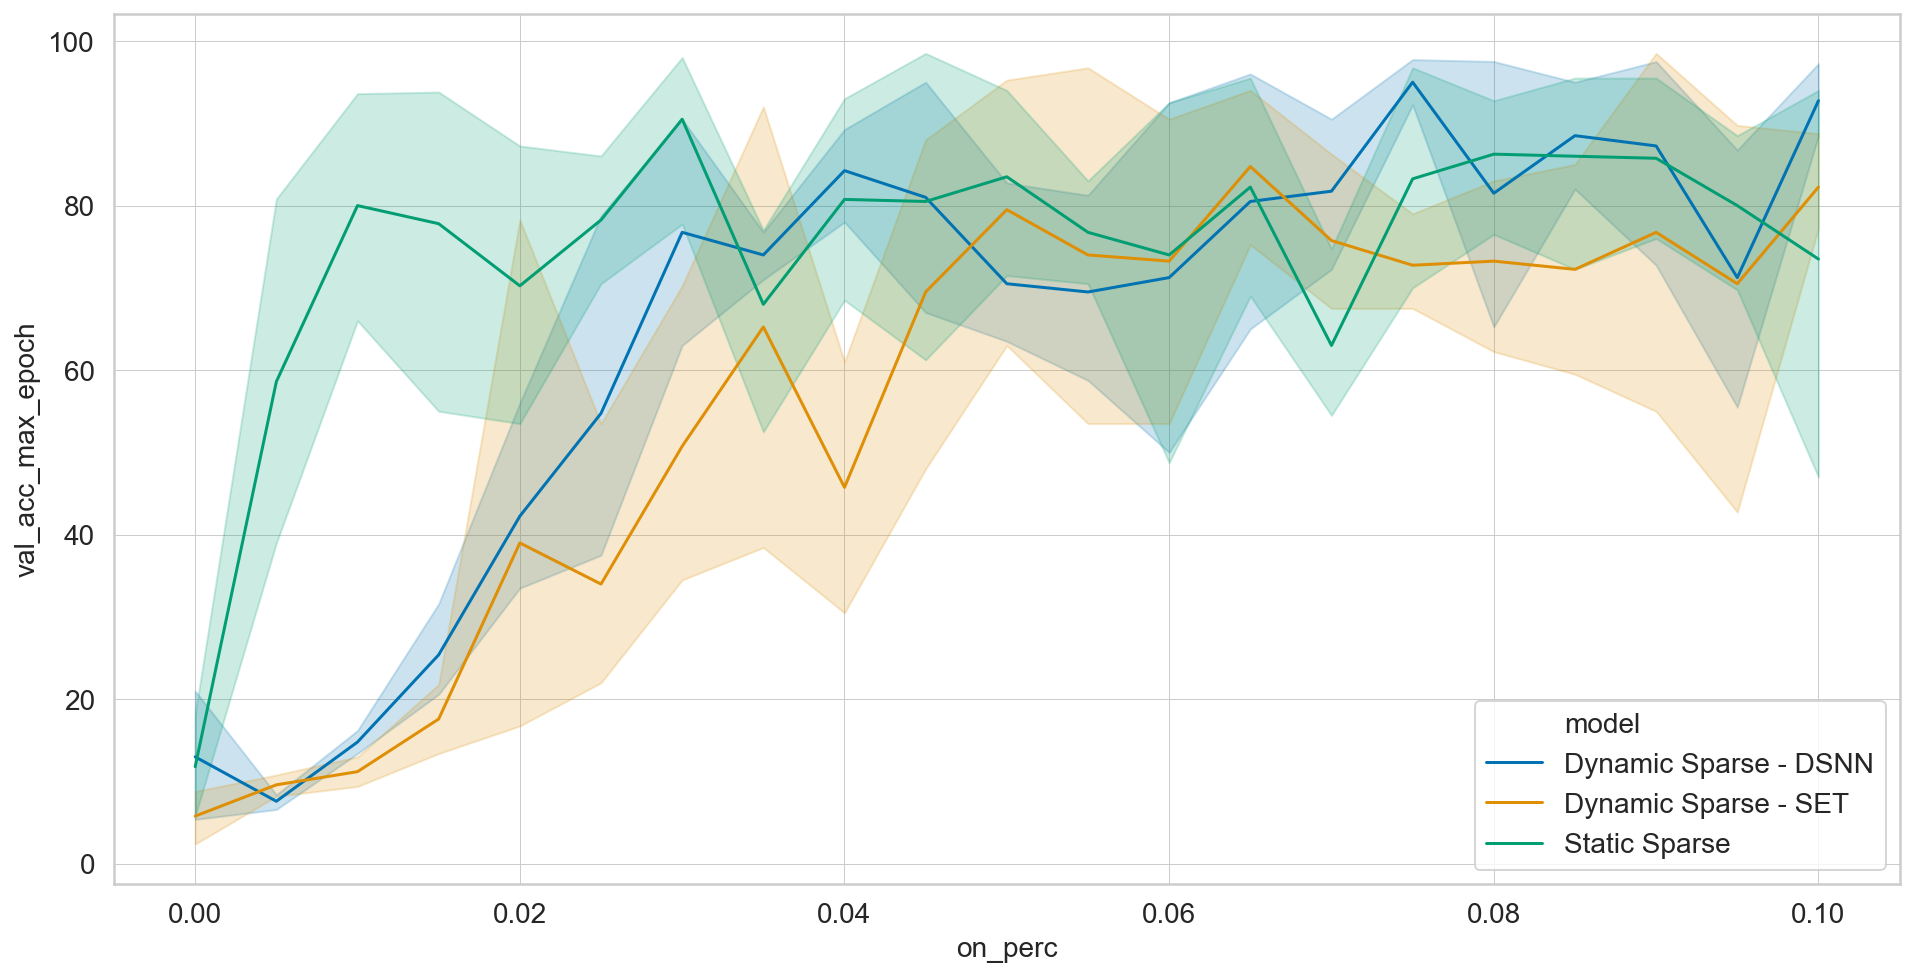

In [22]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

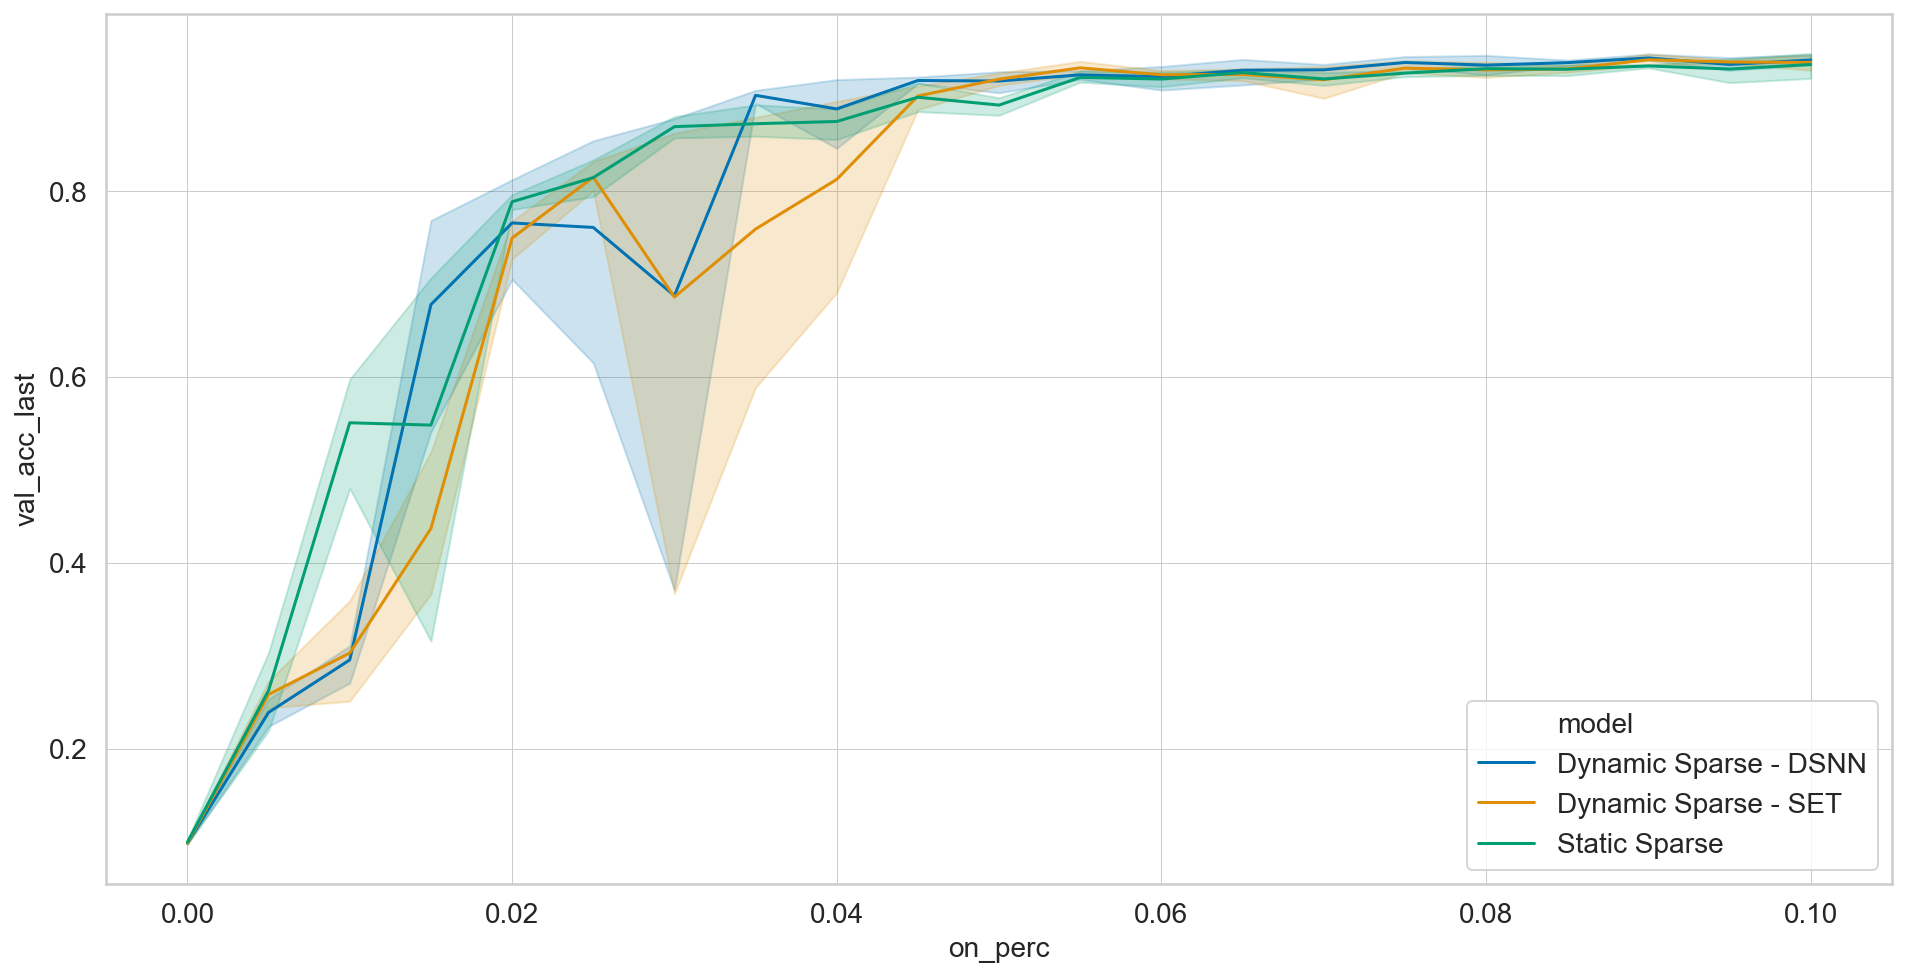

In [23]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')